# OpenCV Tutorial

To help you with the computer vision portion of the project you can make use of the OpenCV python library. This library can help you with the following : 

- the acquisition and display of the image stream from your computer's camera, any external webcam or even a recorded video.
- filtering
- increasing image contrast
- thresholding
- edge detection
- feature matching
- tracking

For a link to the official opencv tutorials, have a look [here](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_table_of_contents_imgproc/py_table_of_contents_imgproc.html)


Note that certain portions of this notebook are taken from [here](https://github.com/dalgu90/opencv-tutorial) 


** Installations **

You will need to install through pip by typing the following in the terminal

`pip3 install opencv-python`

`pip3 install bokeh`

`pip3 install opencv_contrib_python`
    

## 0. Imports

In [1]:
import cv2
import time

import numpy as np

%matplotlib notebook 
import matplotlib.pyplot as plt
%matplotlib notebook

from bokeh.plotting import figure
from bokeh.io import output_notebook, show, push_notebook
from tqdm import tqdm

import IPython.display as Disp
from ipywidgets import widgets


## 1. Loading and Displaying an Image

Here is a short code snippet that shows how to load and display an image that is stored on the disk using opencv. Note the `cv2.IMREAD_COLOR` which determines that the image will be loaded in color. To load an image in black and white, replace that with `cv2.IMREAD_GRAYSCALE`. 


Image Loaded


<IPython.core.display.Javascript object>


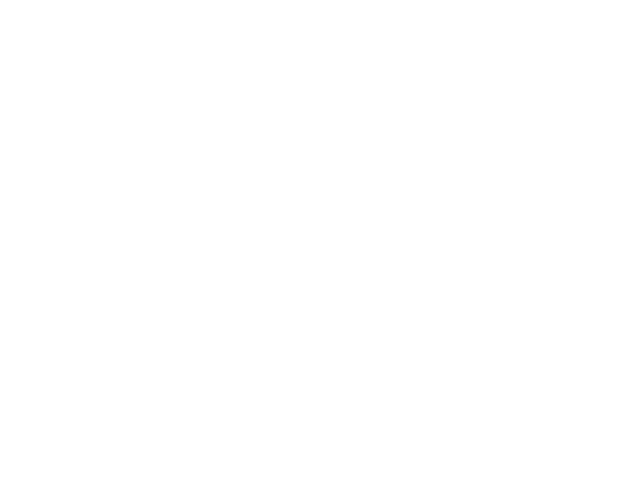

In [2]:
img = cv2.imread('images/thymio_img.png', cv2.IMREAD_COLOR)

# If the image path is wrong, the resulting img will be none
if img is None:
    print('Open Error')
else:
    print('Image Loaded')
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

## 2. Loading and Displaying a Video

Here we are loading a pre-recorded video but the same procedure can be used to acquire video stream from a webcam by replacing the name of the video with the number 0 (generally the ID of the webcam on your computer) or 1 (the ID of the first external camera that was connected to the computer) and so forth. 

This code snippet is adapted from [here](https://www.learnopencv.com/read-write-and-display-a-video-using-opencv-cpp-python/) and [here](https://stackoverflow.com/questions/27882255/is-it-possible-to-display-an-opencv-video-inside-the-ipython-jupyter-notebook)

In [3]:
output_notebook()

# Create a VideoCapture object and read from input file
# If the input is the camera, pass 0 instead of the video file name
cap = cv2.VideoCapture('images/thymio_mov_480p.mov')

# Check if camera opened successfully
if not cap.isOpened(): 
    print("Error opening video stream or file")

# Getting a first frame for the width and height of the plot
ret, frame = cap.read()
frame = cv2.cvtColor(frame[::-1, :,:], cv2.COLOR_BGR2RGBA) # because Bokeh expects a RGBA image and flips images vertically
width, height = frame.shape[1], frame.shape[0]

# Creating the plot
p = figure(x_range=(0,width), y_range=(0,height), output_backend="webgl", width=width, height=height)
myImage = p.image_rgba(image=[frame], x=0, y=0, dw=width, dh=height)
show(p, notebook_handle=True)

# Read until video is completed
while True:
    # Capture frame-by-frame
    ret, frame = cap.read()
    if ret == True:
        # because Bokeh expects a RGBA image and flips images vertically
        frame=cv2.cvtColor(frame[::-1, :,:], cv2.COLOR_BGR2RGBA)
        myImage.data_source.data['image']=[frame]
        push_notebook()
        time.sleep(0.01)
    # Break the loop
    else:
        break

# When everything done, release the video capture object
cap.release()

print("Done displaying the video")

Loading BokehJS ...

Done displaying the video


## 3. Image Processing Pipeline

Taking the image we loaded before, we are going to apply a basic processing pipeline on the image. 

### 3.1. Filtering

In most image processing piepelines, you should start by de-noising the image. Multiple smoothing filters exist of which the Gaussian filter that was seen in the course. 

A few of the ones provided by opencv and that are shown below are:
- averaging
- median filtering
- gaussian filtering 
- bilateral filtering


To see the corresponding opencv tutorial, you can refer to [here](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_filtering/py_filtering.html#filtering)


To illustrate the difference between the filters, the different methods are applied on the image of a seafront taken from [here](https://images.app.goo.gl/GdNGVraY6pgXUNG1A)

<IPython.core.display.Javascript object>


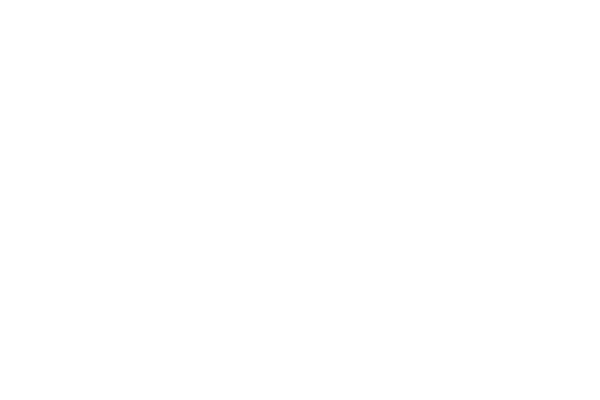

<IPython.core.display.Javascript object>


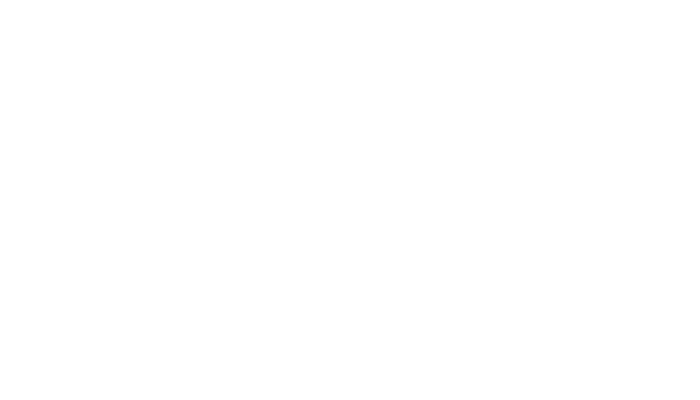

In [4]:
zebra_img = cv2.imread('images/beach.jpg', cv2.IMREAD_COLOR)

plt.figure(figsize=(6,4))
plt.imshow(zebra_img[:,:,::-1])
plt.title("Original")

# Averaging with a 9x9 kernel
avg = cv2.blur(zebra_img,(9,9))

# Median Filtering, effective in removing salt and pepper noise
median = cv2.medianBlur(zebra_img,9)

# Gaussian Filtering with a 10x10 kernel
gauss = cv2.GaussianBlur(zebra_img,(9,9),0)

# Bilateral Filtering 
bilateral = cv2.bilateralFilter(zebra_img,9,75,75)

# Custom Kernel (here equivalent to the average filtering)
kernel = np.ones((9,9),np.float32)/81
custom = cv2.filter2D(zebra_img,-1,kernel)


fig, ax = plt.subplots(2,2, figsize=(7,4))

ax[0][0].imshow(median[:,:,::-1])
ax[0][0].set_title("Median")

ax[0][1].imshow(gauss[:,:,::-1])
ax[0][1].set_title("Gaussian")

ax[1][0].imshow(bilateral[:,:,::-1])
ax[1][0].set_title("Bilateral")

ax[1][1].imshow(custom[:,:,::-1])
ax[1][1].set_title("Custom Kernel (here equivalent to averaging)")

plt.tight_layout()
plt.show()

The advantage of the bilateral filter is that it manages to smooth the image all the while conserving the edges. There is of course a tradeoff in terms of computation time

### 3.2. Histogram Equalization

Because your image does not necessarily use the full spectrum of values between 0 and 255, you can stretch the histogram to cover the full range and as such, improve the contrast of the image. You can refer to the original tutorial [here](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_histograms/py_histogram_equalization/py_histogram_equalization.html#histogram-equalization) for more information

Let's start by plotting the histogram of values contained in our initial image.

<IPython.core.display.Javascript object>


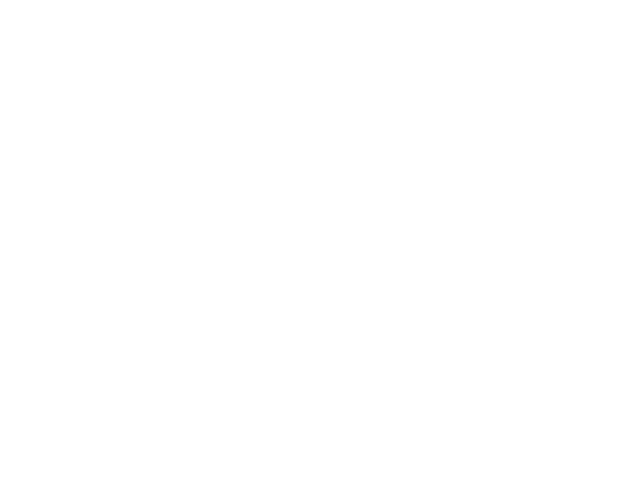

In [5]:
# Converting the original image to black and white

# Bilateral Filtering 
bilateral = cv2.bilateralFilter(img,9,75,75)

bw_img = cv2.cvtColor(bilateral, cv2.COLOR_BGR2GRAY)

hist, bins = np.histogram(bw_img.flatten(),256,[0,256])

cdf = hist.cumsum()
cdf_normalized = cdf * hist.max()/ cdf.max()

plt.figure()
plt.hist(bw_img.flatten(),256,[0,256], color = 'r')
plt.plot(cdf_normalized, color="b")
plt.xlim([0,256])
plt.legend(('histogram', "cdf"), loc = 'upper left')
plt.show()


"**Histogram equalization** is good when histogram of the image is confined to a particular region. It won’t work good in places where there is large intensity variations where histogram covers a large region, ie both bright and dark pixels are present". 

<IPython.core.display.Javascript object>


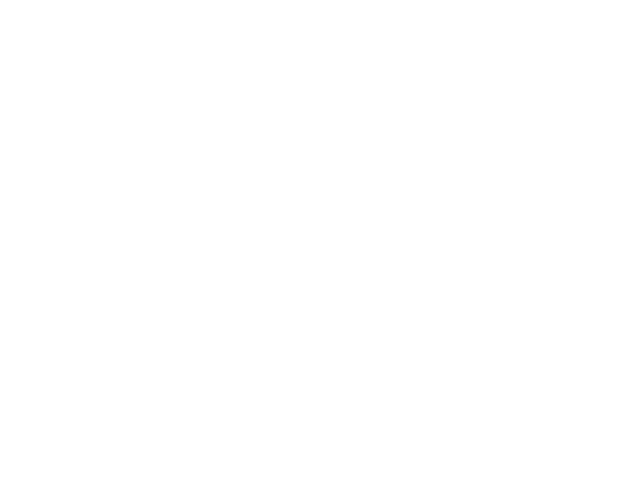

<IPython.core.display.Javascript object>


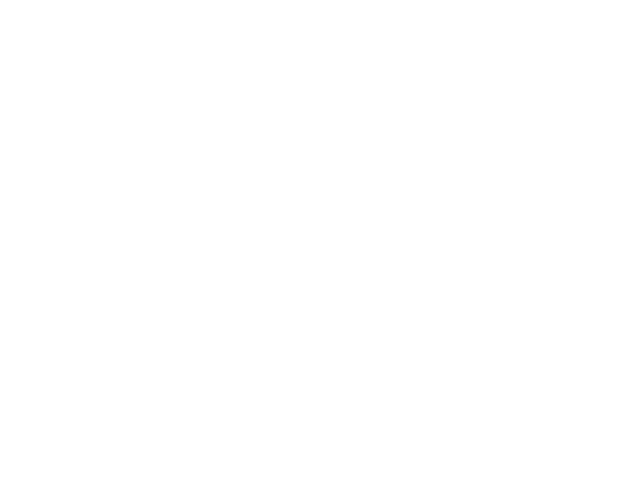

In [6]:
plt.figure()
equ = cv2.equalizeHist(bw_img)
res = np.vstack((bw_img,equ)) #stacking images side-by-side
plt.imshow(res)
plt.title("Original and image with histogram equalization applied to it")

plt.figure()
plt.hist(equ.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.title("Histogram of the processed image")
plt.show()


**CLAHE (Contrast Limited Adaptive Histogram Equalization)** addresses this issue by applying histogram equalization after dividing the image into tiles and applying histogram equalization on each of the tiles. To avoid amplifying noise, contrast limiting is used. That is to say any values above the limit will be clipped. 

<IPython.core.display.Javascript object>


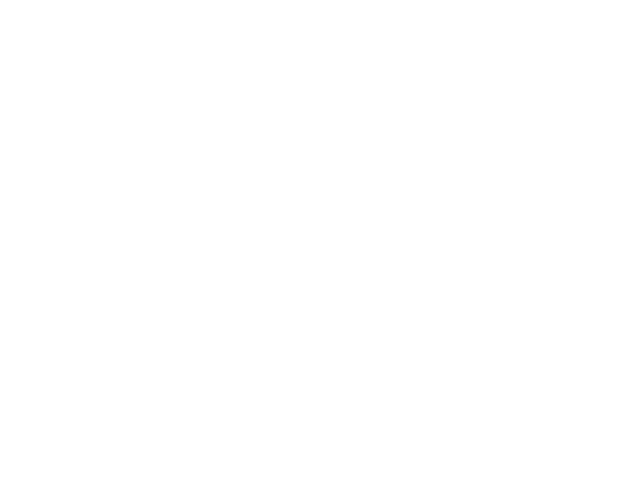

<IPython.core.display.Javascript object>


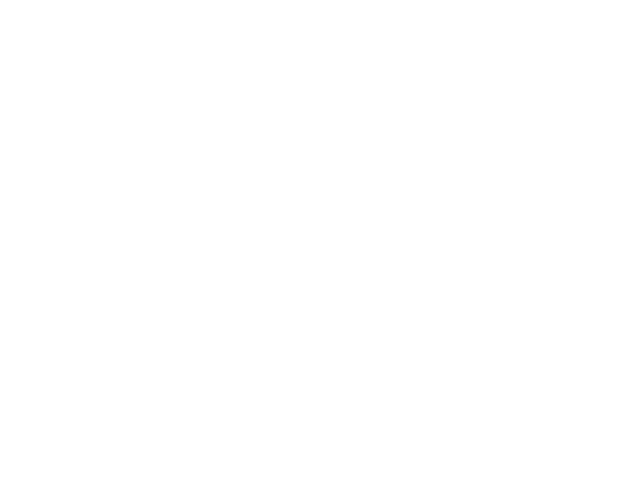

In [7]:
plt.figure()
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl1 = clahe.apply(bw_img)
res = np.vstack((bw_img,cl1)) #stacking images side-by-side
plt.imshow(res)

plt.figure()
plt.hist(cl1.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.title("Histogram of the processed image")
plt.show()

### 3.3. Thresholding

Another way to process the image after filtering could be to threshold the image. Here you can see : 

- binary thresholding using the selected threshold value
- mean adaptive thresholding where " The threshold value is the mean of the neighbourhood area minus the constant C."
- gaussian adaptive thresholding where the threshold value is a gaussian-weighted sum of the neighbourhood values minus the constant C


For the link to the opencv tutorial, look [here](https://docs.opencv.org/3.4/d7/d4d/tutorial_py_thresholding.html)


<IPython.core.display.Javascript object>


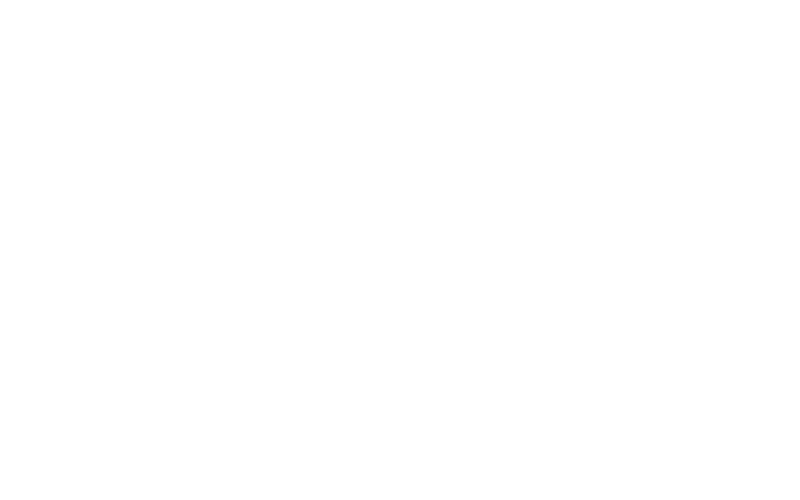

In [8]:
ret,th1 = cv2.threshold(bw_img,165, 220,cv2.THRESH_BINARY)
th2 = cv2.adaptiveThreshold(bw_img,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,11,2)
th3 = cv2.adaptiveThreshold(bw_img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,101,4)
titles = ['Original Image', 'Global Thresholding (v = 127)',
            'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
images = [bw_img, th1, th2, th3]

plt.figure(figsize=(8,5))

for i in range(len(images)):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

** OTSU's Binarization ** 

Determines per region of the image the optimal threshold value based on the histogram values. 

<IPython.core.display.Javascript object>


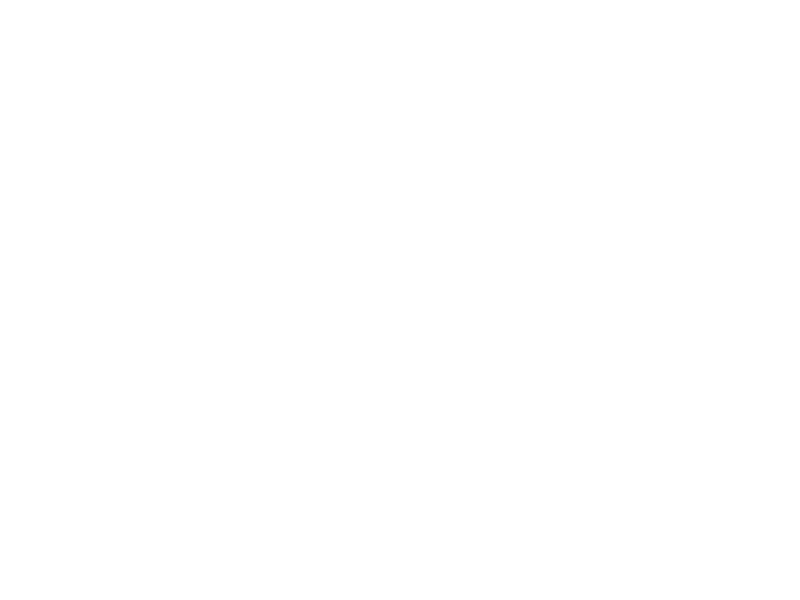

In [9]:
plt.figure(figsize=(8,6))
# global thresholding
ret1,th1 = cv2.threshold(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY),127,255,cv2.THRESH_BINARY)
# Otsu's thresholding
ret2,th2 = cv2.threshold(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY),0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
# Otsu's thresholding after Gaussian filtering
blur = cv2.GaussianBlur(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY),(9,9),0)
ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
# plot all the images and their histograms
images = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), 0, th1,
          cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), 0, th2,
          blur, 0, th3]
titles = ['Original Image','Histogram','Global Thresholding (v=127)',
          'Original Image','Histogram',"Otsu's Thresholding",
          'Gaussian filtered Image','Histogram',"Otsu's Thresholding"]
for i in range(3):
    plt.subplot(3,3,i*3+1),plt.imshow(images[i*3],'gray')
    plt.title(titles[i*3]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+2),plt.hist(images[i*3].ravel(),256)
    plt.title(titles[i*3+1]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+3),plt.imshow(images[i*3+2],'gray')
    plt.title(titles[i*3+2]), plt.xticks([]), plt.yticks([])
plt.show()


You can see that the result is a bit better but there is still some parameter tuning left to do if we want to improve the segmentation. You must realize though that having the Thymio on a white background makes the segmentation more complicated. 

### 3.4. Edge Detection

In the course you saw, the Sobel, Prewitt and Canny Edge filters, all of which are implemented in OpenCV. Here you will get to see the difference between them when applied to the original image


[link1](https://github.com/dalgu90/opencv-tutorial/blob/master/2_edge_detection.ipynb)


<IPython.core.display.Javascript object>


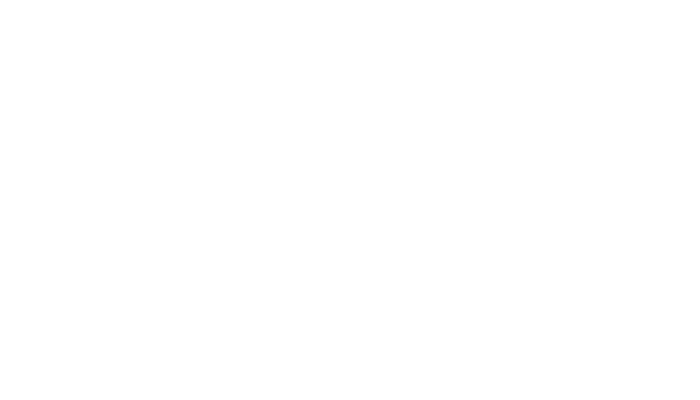

Canny Edge with different thresholds


<IPython.core.display.Javascript object>


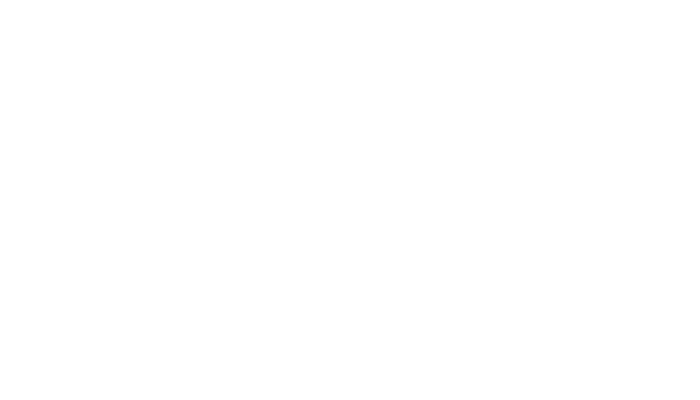

In [10]:
plt.imshow(img[:,:,::-1])

# Converting the original image to black and white
bw_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Filtering the iamge
filtered_img = cv2.bilateralFilter(bw_img,9,75,75)

# Applying different edge detection algorithms
sobelx = cv2.Sobel(filtered_img,cv2.CV_64F,1,0,ksize=5)
sobely = cv2.Sobel(filtered_img,cv2.CV_64F,0,1,ksize=5)
sobel = cv2.sqrt(cv2.addWeighted(cv2.pow(sobelx, 2.0), 1.0, cv2.pow(sobely, 2.0), 1.0, 0.0))

plt.figure(figsize=(7,4))
plt.subplot(2,2,1),plt.imshow(filtered_img,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2),plt.imshow(sobelx,cmap = 'gray')
plt.title('SobelX'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,3),plt.imshow(sobely,cmap = 'gray')
plt.title('SobelY'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,4),plt.imshow(sobel,cmap = 'gray')
plt.title('Sobel'), plt.xticks([]), plt.yticks([])

print("Canny Edge with different thresholds")

canny1 = cv2.Canny(filtered_img, 0, 50)
canny2 = cv2.Canny(filtered_img, 50, 125)
canny3 = cv2.Canny(filtered_img, 125, 200)


plt.figure(figsize=(7,4))
plt.subplot(2,2,1),plt.imshow(filtered_img,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2); plt.title('Canny 0/50'); plt.axis('off');
plt.imshow(canny1, cmap='gray');
plt.subplot(2,2,3); plt.title('Canny 50/125'); plt.axis('off');
plt.imshow(canny2, cmap='gray');
plt.subplot(2,2,4); plt.title('Canny 125/200'); plt.axis('off');
plt.imshow(canny3, cmap='gray');



So even though the canny edge filter is usually better than the sobel filter, with this image, we aren't getting too far along

# 4. Blob Detection


Blob detection helps identify regions in an image ["that share some common property ( E.g grayscale value )". "OpenCV provides a convenient way to detect blobs and filter them based on different characteristics"](https://www.learnopencv.com/blob-detection-using-opencv-python-c/)

Some of the characteristics that you can play with are illustrated in the following image : 

<img src="images/blob_detection_params.png"
     alt="Markdown Monster icon"
     style="float: left; margin-right: 10px;" />


Here you will see how you can play with blob detection to isolate the Thymios (with the help of morphological operators) and once to isolate the colored cubes in the following image 

<img src="images/playground.jpeg"
     alt="Markdown Monster icon"
     style="float: left; margin-right: 10px;" />


<IPython.core.display.Javascript object>


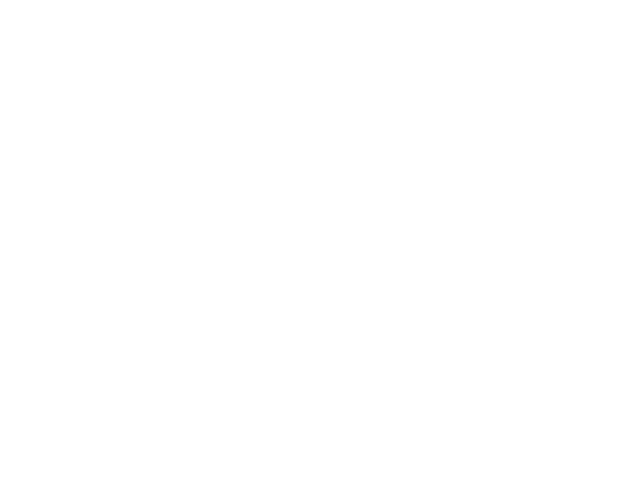

<IPython.core.display.Javascript object>


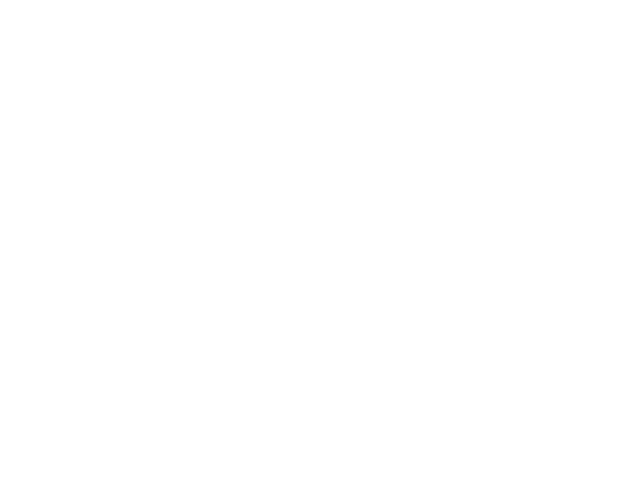

<IPython.core.display.Javascript object>


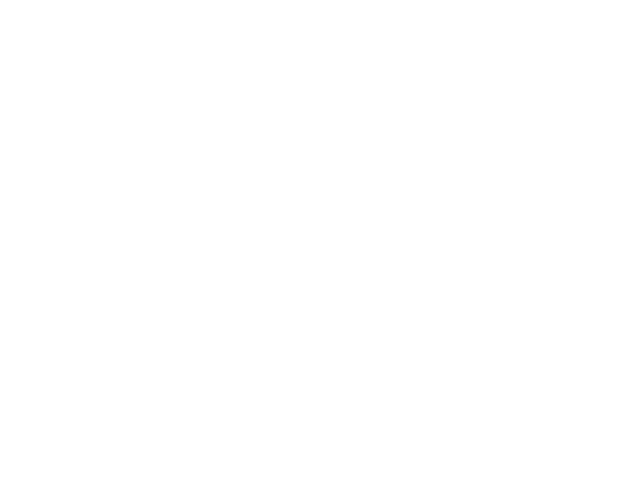

<IPython.core.display.Javascript object>


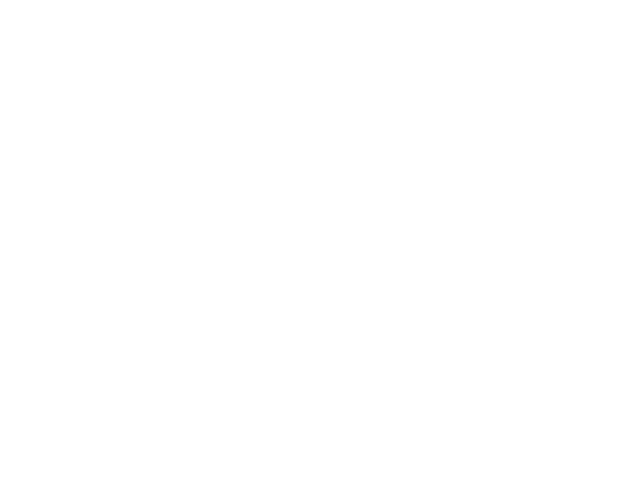

In [11]:
img = cv2.imread('images/playground.jpeg', cv2.IMREAD_GRAYSCALE)
plt.figure()
plt.imshow(img)
plt.title("0. Original image in black and white")
plt.show()

# Pre-processing the image through filtering, histogram equalisation and thresholding
bilateral = cv2.bilateralFilter(img,9,25,25)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl1 = clahe.apply(bilateral)

plt.figure()
plt.imshow(cl1)
plt.title("1. Filtering followed by histogram equalisation")
plt.show()

# Thresholding
thresh = cv2.threshold(cl1, 220, 255, cv2.THRESH_BINARY_INV)[1]
plt.figure()
plt.imshow(thresh)
plt.title("2. Thresholding")
plt.show()

# Applying morphological operators to the image
kernel = np.ones((5,5),np.uint8)
morph = cv2.dilate(thresh, None, iterations=4)
morph = cv2.erode(morph, None, iterations=10)

plt.figure()
plt.imshow(morph)
plt.title("3. Morphological operators on the thresholded image")
plt.show()


After the processing we can see that the binarized patches overlap pretty well with the positions of the Thymios. This makes it easier to apply blob detection on a binary grayscale image (i.e. with either the value 0 or 255). 

<IPython.core.display.Javascript object>


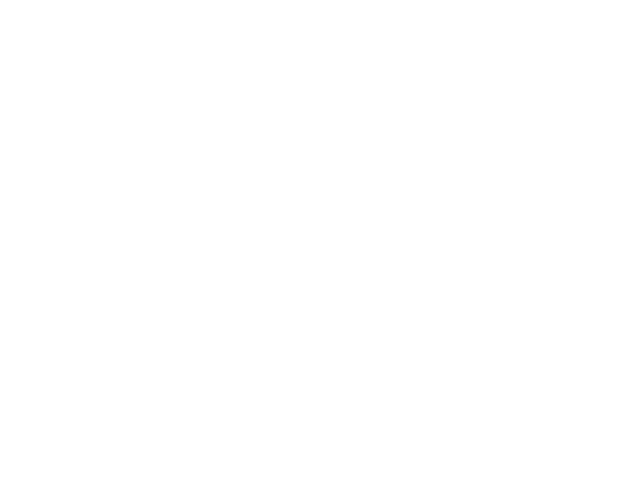

In [12]:

# Setup SimpleBlobDetector parameters.
params = cv2.SimpleBlobDetector_Params()
 
# Change thresholds
params.minThreshold = 200;
params.maxThreshold = 255;
 
# Filter by Area.
params.filterByArea = False
params.minArea = 0
params.maxArea = 400
 
# Filter by Circularity
params.filterByCircularity = False
params.minCircularity = 0.4
 
# Filter by Convexity
params.filterByConvexity = False
params.minConvexity = 0.5

params.filterByColor = False
 
detector = cv2.SimpleBlobDetector_create(params)

# Detect blobs.
keypoints = detector.detect(morph)
 
img = cv2.imread('images/playground.jpeg', cv2.IMREAD_COLOR)

# Draw detected blobs as red circles.
# cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob
im_with_keypoints = cv2.drawKeypoints(img, keypoints, np.array([]), (255,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
 
# Show keypoints
plt.figure()
plt.imshow(im_with_keypoints)
plt.title("Pink circles around the detected Thymios")
plt.show()

So the blob detection worked pretty well but it seems that one blob is out of place. Instead of being at the level of the bottom most Thymio like it was in the binarized image, it is shifted to the coordinates x=250, y=320. The algorithm is not perfect.

You can also filter by color on the originall image to isolate the colored blocs in the image. Do not forget to have a look at the histogram of the image to figure out where to place the thresholds. You can see two peaks for the different colors, a small one around 50 and a larger one around 150. Since we are looking for the coloured blocs, it is more likely that we are interested in the peak around 150. That is why the thresholds were selected to keep the values in that range. 

<IPython.core.display.Javascript object>


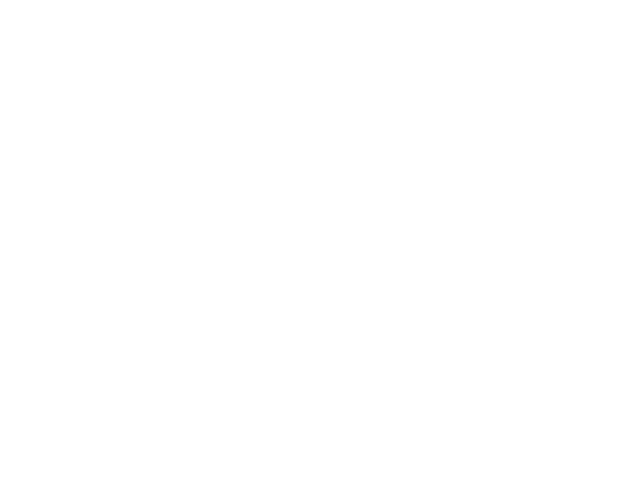

<IPython.core.display.Javascript object>


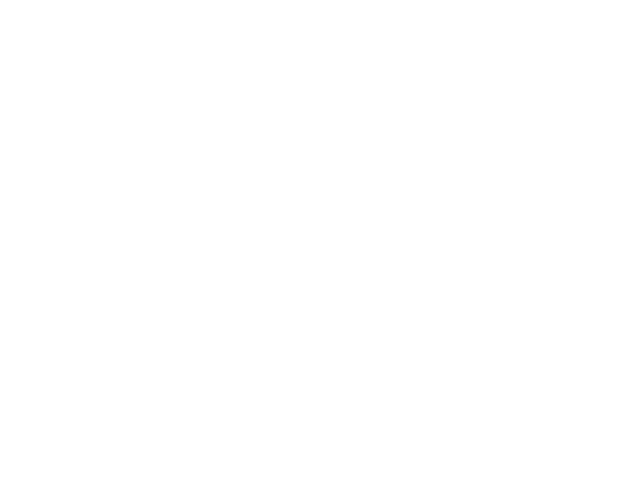

In [13]:
img = cv2.imread('images/playground.jpeg', cv2.IMREAD_COLOR)
bilateral = cv2.bilateralFilter(img,20,75,75)

plt.figure()
plt.hist(bilateral[:,:,0].ravel(),256,[0,256], color="b"); 
plt.hist(bilateral[:,:,1].ravel(),256,[0,256], color="g"); 
plt.hist(bilateral[:,:,2].ravel(),256,[0,256], color="r"); 
plt.title("RGB histogram of the filtered image")
plt.show()


# Setup SimpleBlobDetector parameters.
params = cv2.SimpleBlobDetector_Params()
 
# Change thresholds
params.minThreshold = 75;
params.maxThreshold = 200;
 
# Filter by Area.
params.filterByArea = True
params.minArea = 200
params.maxArea = 1500
 
# Filter by Circularity
params.filterByCircularity = False
params.minCircularity = 0
params.maxCircularity = 0.9

 
# Filter by Convexity
params.filterByConvexity = False
params.minConvexity = 0.6

params.filterByColor = False
 
detector = cv2.SimpleBlobDetector_create(params)

# Detect blobs.
keypoints = detector.detect(bilateral)
 
img = cv2.imread('images/playground.jpeg', cv2.IMREAD_COLOR)

# Draw detected blobs as red circles.
# cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob
im_with_keypoints = cv2.drawKeypoints(img, keypoints, np.array([]), (255,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
 
# Show keypoints
plt.figure()
plt.imshow(im_with_keypoints)
plt.title("Blob detection on the filtered image. \n Coloured blocs in pink")
plt.show()

Note that when using the blob detection proposed by opencv you need to consider all the default parameters. For example, when filtering on a gray image, you need to set the filter by color parameter to False because the default value is True. 

# 5. Template Matching

[OpenCV tutorial link](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_template_matching/py_template_matching.html)


To illustrate how template matching works we will use a video and a crop of one of the frames.


First let's start by loading and storing the frames of the video

In [14]:
cap = cv2.VideoCapture('images/thymio_line_following.mp4')

# Check if camera opened successfully
if not cap.isOpened(): 
    print("Error opening video stream or file")

video_imgs = []

while True:
    ret, frame = cap.read()
    if ret == True:
        video_imgs.append(frame)
    # Break the loop
    else:
        break
        
print("There are {} frames in the video".format(len(video_imgs)))

There are 965 frames in the video


Let's take one of the frames and crop the Thymio to make our template. In frame 420, the Thymio is located between x = \[446, 611\] and y = \[312, 484\] (determined using the cursor on the image). Why are we doing it this way? Template matching does not work well if you take a reference / template image that is not to scale w.r.t the image you are going to be looking in. One solution is to use multi-scale [template matching](https://www.pyimagesearch.com/2015/01/26/multi-scale-template-matching-using-python-opencv/). We are not going to go into that here but the link provided gives an example of how that could be implemented.  

<IPython.core.display.Javascript object>


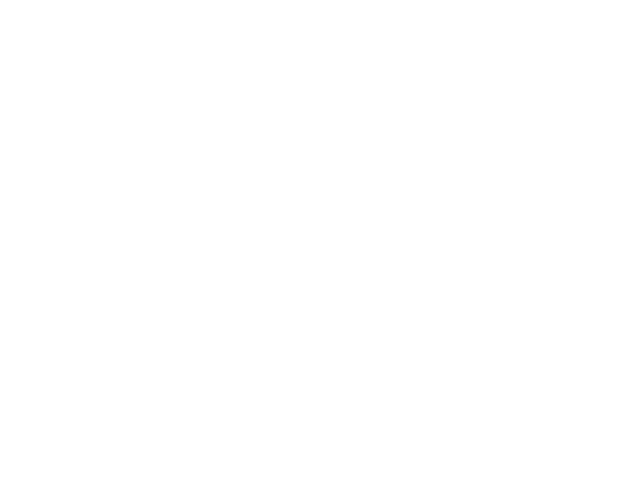

In [15]:
plt.figure()
plt.imshow(video_imgs[420][:,:,::-1])
plt.show()

/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


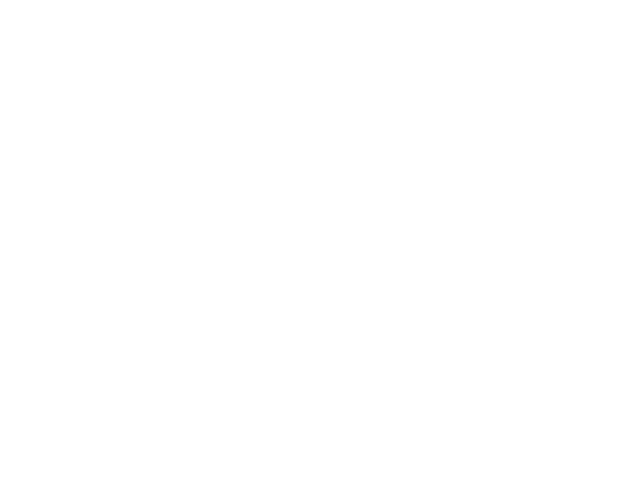

In [16]:
template = video_imgs[420][312:484,446:611,:]
plt.figure()
plt.imshow(template)
plt.show()

/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


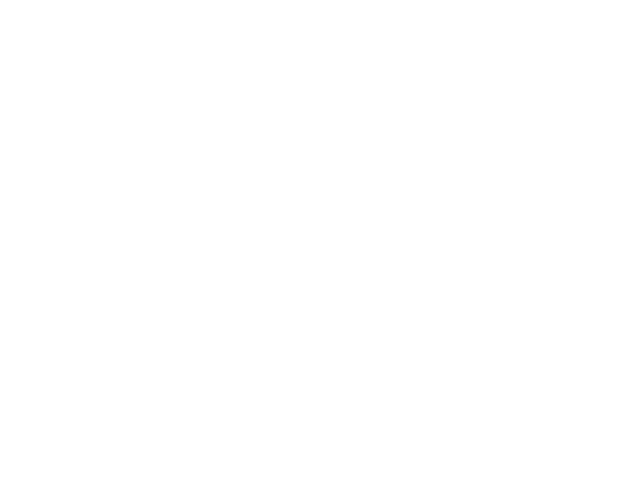

<IPython.core.display.Javascript object>


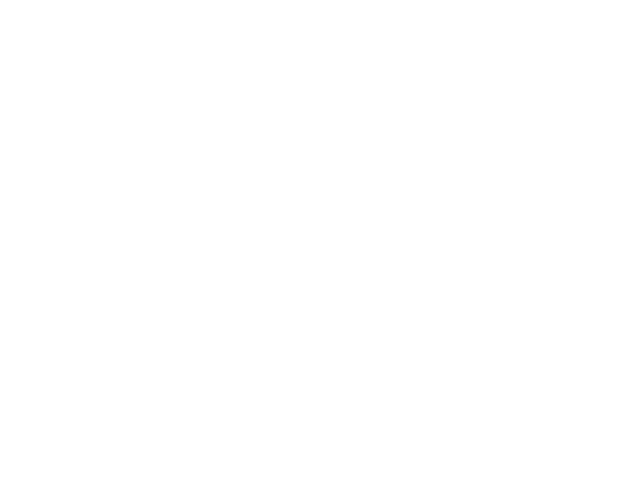

<IPython.core.display.Javascript object>


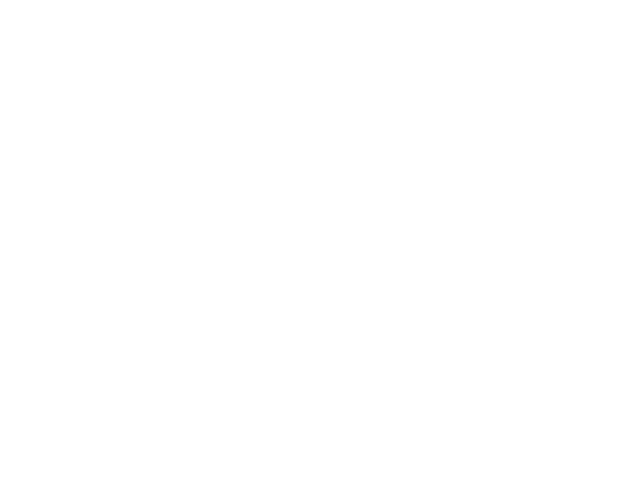

<IPython.core.display.Javascript object>


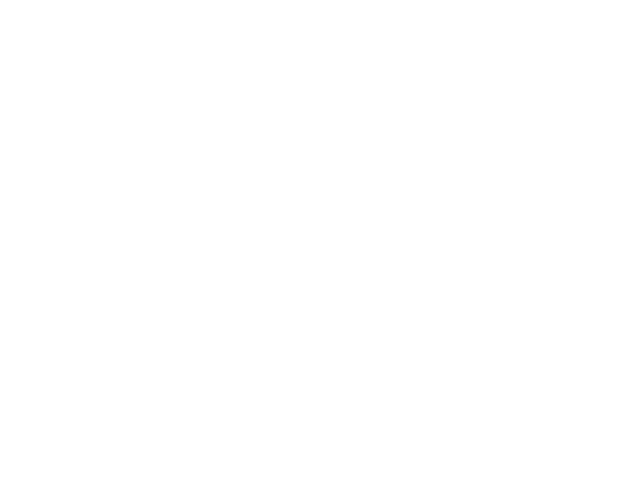

<IPython.core.display.Javascript object>


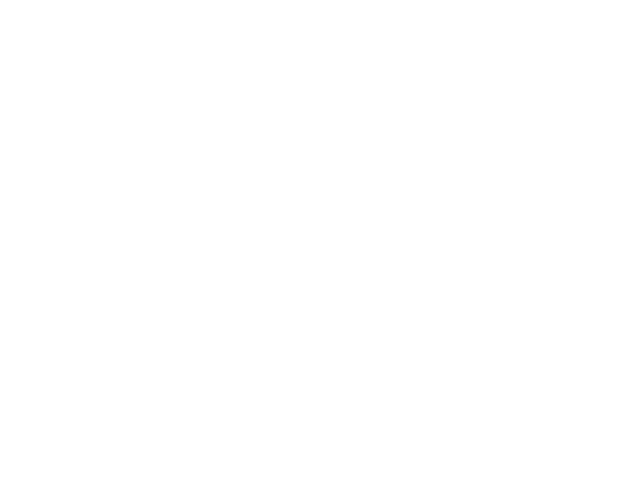

<IPython.core.display.Javascript object>


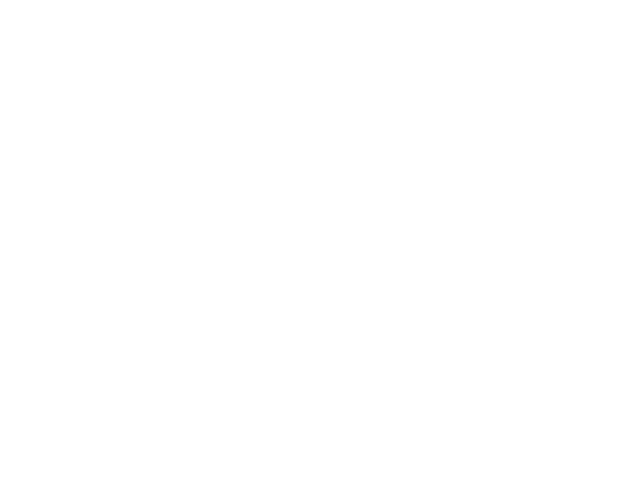

In [17]:
c, w, h  = template.shape[::-1]

methods = ['cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR',
            'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED']

for meth in methods:
    method = eval(meth)
    img = video_imgs[420].copy()
    
    # Apply template Matching
    res = cv2.matchTemplate(img,template,method)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

    # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
    if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)

    cv2.rectangle(img,top_left, bottom_right, (255, 0, 0), -1)
    
    plt.figure()
    plt.subplot(121),plt.imshow(res,cmap = 'gray')
    plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(img,cmap = 'gray')
    plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
    plt.suptitle(meth)

    plt.show()

Looking at the matching results, it would seem that cv2.TM_CCOEFF_NORMED gives the highest contrast between the found point and the rest. Let's run this method on the whole video and see the results 

In [18]:
template_matching_on_video = []
titles = []

for idx_frame in tqdm(range(len(video_imgs))):
    img = video_imgs[idx_frame].copy()

    # Apply template Matching
    res = cv2.matchTemplate(img,template,cv2.TM_CCOEFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
    
    titles.append("Frame {}, top left corner of thymio located at {}".format(idx_frame, top_left))
    cv2.rectangle(img, top_left, bottom_right, (255, 0, 0), -1)
    template_matching_on_video.append(img)


100%|██████████| 965/965 [00:25<00:00, 37.63it/s]


In [19]:
from ipywidgets import interact
%matplotlib inline

def browse_images(images, titles):
    n = len(images)
    def view_image(i):
        plt.imshow(images[i], cmap=plt.cm.gray_r, interpolation='nearest')
        plt.title(titles[i], y=-0.5)
        plt.show()
    interact(view_image, i=(0,n-1))

titles 
browse_images(template_matching_on_video, titles)


interactive(children=(IntSlider(value=482, description='i', max=964), Output()), _dom_classes=('widget-interac…

"**[Limitations of Template Matching](https://www.geeksforgeeks.org/template-matching-using-opencv-in-python/)**:

- Pattern occurrences have to preserve the orientation of the reference pattern image(template)
- As a result, it does not work for rotated or scaled versions of the template as a change in shape/size/shear etc. of object w.r.t. template will give a false match.
- The method is inefficient when calculating the pattern correlation image for medium to large images as the process is time consuming."


# 5. Tracking

OpenCV has quite a few trackers integrated into the library. Here is an example of how you can setup a tracker on one or more of the robots in the video shown. 

Example taken from [here](https://www.learnopencv.com/multitracker-multiple-object-tracking-using-opencv-c-python/)


**Creating a Tracker**

In [20]:
from random import randint
 
trackerTypes = ['BOOSTING', 'MIL', 'KCF','TLD', 'MEDIANFLOW', 'GOTURN', 'MOSSE', 'CSRT']
 
def createTrackerByName(trackerType):
    # Create a tracker based on tracker name
    if trackerType == trackerTypes[0]:
        tracker = cv2.TrackerBoosting_create()
    elif trackerType == trackerTypes[1]: 
        tracker = cv2.TrackerMIL_create()
    elif trackerType == trackerTypes[2]:
        tracker = cv2.TrackerKCF_create()
    elif trackerType == trackerTypes[3]:
        tracker = cv2.TrackerTLD_create()
    elif trackerType == trackerTypes[4]:
        tracker = cv2.TrackerMedianFlow_create()
    elif trackerType == trackerTypes[5]:
        tracker = cv2.TrackerGOTURN_create()
    elif trackerType == trackerTypes[6]:
        tracker = cv2.TrackerMOSSE_create()
    elif trackerType == trackerTypes[7]:
        tracker = cv2.TrackerCSRT_create()
    else:
        tracker = None
        print('Incorrect tracker name')
        print('Available trackers are:')
        for t in trackerTypes:
            print(t)

    return tracker

**Loading the Video**

In [21]:
# Create a video capture object to read videos
cap = cv2.VideoCapture('images/thymio_mov_480p.mov')
 
# Read first frame
success, frame = cap.read()

width, height = frame.shape[1], frame.shape[0]

# quit if unable to read the video file
if not success:
    print('Failed to read video')
    sys.exit(1)

**Locating the Objects in the First Frame** 

Note that a window will open up witth the first frame of the video and there you will have to manually select the area or areas that you want to track

In [22]:
## Select boxes
bboxes = []
colors = [] 
 
# OpenCV's selectROI function doesn't work for selecting multiple objects in Python
# So we will call this function in a loop till we are done selecting all objects
i = 0

while True:
    print("Ready to select new ROI")
    i += 1
    # draw bounding boxes over objects
    # selectROI's default behaviour is to draw box starting from the center
    # when fromCenter is set to false, you can draw box starting from top left corner
    bbox = cv2.selectROI('MultiTracker', frame)
    bboxes.append(bbox)
    colors.append((randint(0, 255), randint(0, 255), randint(0, 255)))
    print("Object {}, bbox {}".format(i, bbox))
    print("Press **q** to quit selecting boxes and start tracking")
    print("Press any other key to select next object \n")
    k = cv2.waitKey(0) & 0xFF
    if (k == 113):  # q is pressed
        break

print('Selected bounding boxes {}'.format(bboxes))

Ready to select new ROI
Object 1, bbox (372, 201, 79, 78)
Press **q** to quit selecting boxes and start tracking
Press any other key to select next object 

Ready to select new ROI
Object 2, bbox (144, 177, 80, 78)
Press **q** to quit selecting boxes and start tracking
Press any other key to select next object 

Selected bounding boxes [(372, 201, 79, 78), (144, 177, 80, 78)]


**Setting up the Tracker**

In [25]:
# Instead of MIL, you can also use
# BOOSTING, KCF, TLD, MEDIANFLOW or GOTURN
# Specify the tracker type
trackerType = "CSRT"   
 
# Create MultiTracker object
multiTracker = cv2.MultiTracker_create()
 
# Initialize MultiTracker 
for bbox in bboxes:
    multiTracker.add(createTrackerByName(trackerType), frame, bbox)

** Updating the multitracker and displaying the results **

In [24]:
output_notebook()

# Creating the plot
p = figure(x_range=(0,width), y_range=(0,height), output_backend="webgl", width=width, height=height)
myImage = p.image_rgba(image=[frame], x=0, y=0, dw=width, dh=height)
show(p, notebook_handle=True)

# Process video and track objects
while cap.isOpened():
    success, frame = cap.read()
    if not success:
        break

    # get updated location of objects in subsequent frames
    success, boxes = multiTracker.update(frame)

    # draw tracked objects
    for i, newbox in enumerate(boxes):
        p1 = (int(newbox[0]), int(newbox[1]))
        p2 = (int(newbox[0] + newbox[2]), int(newbox[1] + newbox[3]))
        cv2.rectangle(frame, p1, p2, colors[i], 2, 1)

    # show frame
    #cv2.imshow('MultiTracker', frame)
    frame=cv2.cvtColor(frame[::-1, :,:], cv2.COLOR_BGR2RGBA)# because Bokeh expects a RGBA image and flips images vertically
    myImage.data_source.data['image']=[frame]
    push_notebook()
    time.sleep(0.01)
    # quit on ESC button
    if cv2.waitKey(1) & 0xFF == 27:  # Esc pressed
        break

# When everything done, release the video capture object
cap.release()

print("Done displaying the video")

Loading BokehJS ...

Done displaying the video
